In [20]:
!pip install matplotlib-venn imblearn transformers tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/Shareddrives/DepSign/data

[Errno 2] No such file or directory: 'drive/Shareddrives/DepSign/data'
/content/drive/Shareddrives/DepSign/data


In [34]:
import re

from transformers import AutoTokenizer
from imblearn.over_sampling import RandomOverSampler
from matplotlib_venn import venn3_unweighted
import plotly.express as px
from tqdm.auto import tqdm
import pandas as pd

tqdm.pandas()

In [ ]:
splits = ["train", "dev"]

data = list()

for split in splits:
  df = pd.read_csv(f"{split}_data.csv")
  df["split"] = split
  data.append(df)

  if "Class labels" in df.columns:
    df.rename(columns={"Class labels": "label"}, inplace=True)

  df.columns = df.columns.str.lower()
  df.rename(columns={"text data": "text"}, inplace=True)
  df["text"] = df["text"].str.strip()


data = pd.concat(data)

In [ ]:
data

,pid,text,label,split
0,train_pid_1,Waiting for my mind to have a breakdown once t...,moderate,train
1,train_pid_2,My new years resolution : I'm gonna get my ass...,moderate,train
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,moderate,train
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",moderate,train
4,train_pid_5,Sat in the dark and cried myself going into th...,moderate,train
...,...,...,...,...
3240,dev_pid_3241,"Feeling lonely. : Hi reddit, I haven’t posted ...",severe,dev
3241,dev_pid_3242,When would suicide be right? : So I got back f...,severe,dev
3242,dev_pid_3243,Lowest I’ve ever been ever. : To make a long s...,severe,dev
3243,dev_pid_3244,Does the Toxoplasma Gondii ruined my life ? (f...,severe,dev


In [ ]:
data["split"].value_counts()

train    7201
dev      3245
Name: split, dtype: int64

In [ ]:
px.pie(data, "label", facet_col="split")

In [ ]:
data["n_words"] = data["text"].apply(lambda t: len(re.split(r"\s+", t.strip())))

In [ ]:
data.describe()

,n_words
count,10446.000000
mean,164.985353
std,223.695891
min,2.000000
25%,44.000000
50%,101.000000
75%,205.000000
max,4984.000000


In [ ]:
data["n_words_bins"] = pd.cut(data["n_words"], bins=[0, 300,600, data["n_words"].max()]).astype(str)

In [ ]:
data.value_counts(subset=["split", "label"])

split  label         
train  moderate          3678
       not depression    2755
dev    moderate          2169
       not depression     848
train  severe             768
dev    severe             228
dtype: int64

In [ ]:
px.pie(data, "n_words_bins", color_discrete_sequence=["green", "orange", "red"], facet_col="split")

In [23]:
tokenizer = AutoTokenizer.from_pretrained("roberta-large")

In [36]:
data["n_tokens"] = data["text"].progress_apply(lambda t: len(tokenizer.tokenize(t)))

  0%|          | 0/10446 [00:00<?, ?it/s]

In [53]:
data["n_tokens"].max()

5751

In [66]:
total = pd.cut(data["n_tokens"], [0, 512, 6000], right=False).value_counts()
total/data.shape[0]*100

[0, 512)       92.360712
[512, 6000)     7.639288
Name: n_tokens, dtype: float64

In [49]:
fig = px.histogram(data, "n_tokens", template="plotly_white")
fig.add_vline(x=512, line_dash="dot")
fig.update_layout(
    autosize=False,
    width=400,
    height=400,
)

In [ ]:
counts = data[["label", "n_words_bins"]].value_counts().reset_index()
counts = pd.pivot(counts, columns="label", index="n_words_bins", values=0)
counts = counts.apply(lambda col: [cell/col.sum() for cell in col])
counts = counts[["not depression", "moderate",	"severe"]]
counts

label,not depression,moderate,severe
n_words_bins,,,
"(0, 300]",0.904246,0.849838,0.727912
"(300, 600]",0.073272,0.113220,0.208835
"(600, 4984]",0.022481,0.036942,0.063253


In [ ]:
data[data["label"] == "not depression"].head(n=5)["text"].to_list()

['i lost my virginity and 5 mins later my gf said she wasnt over her ex : i feel dead inside i just want to die',
 'This is a question that gives me SO MUCH anxiety and stress, please help me out : I am 16M and i have a raised mole above my lip (where a moustache grows)\n\nI know it’s not cancerous but i don’t like it.\n\nI am also too shy to ask my parents about removing it, but i will ask, but im worried, if i remove it, can i still grow hair in that same area? \nCause i really don’t want a blank spot in my moustache.\n\nAny help is appreciated.',
 "Insecurities, fuck em. : I constantly feel like anyone I talk to at all, or act like myself around is just trying to get me to shut up.\n\nIm tired of being disgusted of what I see in the mirror.\n\nI just to have a friend of the opposite gender that I can cuddle with or hug.\n\nNothing sexual about it, I'd just like to cuddle with someone of the opposite sex. I feel lonely and I honestly could just hug someone for like, hours probably.. 

In [ ]:
data[(data["label"] == "severe") & (data["n_words"] < 100)]["text"].to_list()

["I can't do this anymore. : I have several mental health issues including Aspergers, depression, OCD, suspected BPD, anxiety and so on. I'm only 22 but I seriously don't see the point in living anymore. My dad died in 2018 and ever since then I've been worse. I lost my job, I don't have any friends, me and my partner always argue and we're going through crap now, my mums an alcoholic. I cannot do this anymore",
 'Hi I\'m unwell : I\'m 21 now, "vice ridden", and I think about how I went from going to a Voc-Tech high school, tons of friends to a recluse with schizophrenia\n\nJust last Thursday i literally tore teeth out \n\nIm searching for professional help again though i can\'t live like this',
 "I feel like shit : I feel like shit. I've cried non stop for the past 5 days. Not sure what's going on. Ever since my 16th birthday a month ago everything has gone downhill. I'm suicidal but I'm too afraid to tell anyone. My nurse increased my meds about 3 months ago but I feel worse. I can't

In [ ]:
data[data["label"] == "moderate"].sample(n=3, random_state=2)["text"].to_list()

["Wellbutrin to Remeron : So my doctor switched me from Wellbutrin to Remeron because I literally could not sleep on Wellbutrin. Now with Remeron all I want to do is sleep, and I can not get the energy to do every day tasks. It's only been a few days. Has anyone made this change? Please tell me I won't feel like a tired zombie forever on this stuff. I'm so close to weening myself off antidepressants altogether.",
 "I don't know why I'm depressed : I have been feeling down for about 3 weeks.. I don't know why or exactly when it started. I'm usually doing alright in the day, meaning I dont feel suicidal or too depressed but in the evenings i feel so lonely and depressed I get suicidal. I am 16 years old and I have always hated drugs and alcohol but I got a friend who said he can sell some weed(which is fairly uncommon where I live) and I drank some alcohol my dad had after my parents went to sleep. I don't feel like burdening anyone with telling them how I feel but i don't know what to d

In [ ]:
data[data["label"] == "severe"].sample(n=3, random_state=3)["text"].to_list()

['Needing a friend : Hey, I\'m Ash. I\'ve had depression for the majority of my life mostly due to my father\'s death in 2012. My anxiety and depression are hitting me really hard today. I just found out that my only friend removed me from her friend list on snap chat. I have no work friends. I\'m not good at reaching out to people. I\'ve done a lot of bad things and made wrong choices in my life, and now realize that I dont want to go on this journey alone. \nA little about me: I\'m 26, birthday is July 20th. I have 2 kids and a failed marriage. I have a loving fiance that treats us like gold. I enjoy netflix and gaming. I\'m a phlebotomist at a local hospital working overnight, so I\'m a bit of a night owl. I\'m in the kansas city, mo area. \nJust looking for some people I could reach out to in a tough time. Maybe go do lunch or have group dates. Or even just someone to reply to my "I dont know if I can do this" texts. Men, women, theys, thems, its, whatever. I\'m accepting of all ty

### Observações
- Como lidar com gírias da internet (dataset de análise de sentimentos da net?)
- Como lidar com "pegas"? Acho que teremos muitos falsos positivos
- Depressão é fácil de localizar

In [ ]:
data["text"].duplicated().sum()

210

In [ ]:
duplicated = data[data["text"].duplicated(keep=False)]
duplicated = duplicated.sort_values(["text", "label", "split"]).reset_index(drop=True)

duplicated

,pid,text,label,split,n_words,n_words_bins
0,train_pid_948,"""why don't you talk about how you feel?"" Ok he...",moderate,train,16,"(0, 300]"
1,train_pid_6344,"""why don't you talk about how you feel?"" Ok he...",not depression,train,16,"(0, 300]"
2,train_pid_6228,(UK) Can I get sectioned if I ‘m not a danger ...,not depression,train,95,"(0, 300]"
3,train_pid_2413,(UK) Can I get sectioned if I ‘m not a danger ...,severe,train,95,"(0, 300]"
4,dev_pid_1520,. : Whatever you think you can be isn’t real. ...,moderate,dev,15,"(0, 300]"
...,...,...,...,...,...,...
413,train_pid_6287,something i've wrote a few minutes ago : and s...,not depression,train,42,"(0, 300]"
414,train_pid_954,this is hell : my head is killing me it’s bad ...,moderate,train,127,"(0, 300]"
415,train_pid_4215,this is hell : my head is killing me it’s bad ...,moderate,train,127,"(0, 300]"
416,train_pid_946,this is very long but i have to get it off my ...,moderate,train,621,"(600, 4984]"


In [ ]:
duplicated.iloc[70:75]

,pid,text,label,split
70,train_pid_2432,Doctor doubled my medication : Going up from 1...,severe,train
71,train_pid_7012,Doctor doubled my medication : Going up from 1...,severe,train
72,dev_pid_1389,Does anyone else feel this way? : [removed],moderate,dev
73,train_pid_2221,Does anyone else feel this way? : [removed],not depression,train
74,train_pid_6354,Does anyone else feel this way? : [removed],not depression,train


In [ ]:
duplicated_f = data.duplicated(subset="text")

total = duplicated_f.sum()
only_text = (data.duplicated(subset="text")  & ~data.duplicated(subset=["text", "label"]) & ~data.duplicated(subset=["text", "split"])).sum()
text_label = (data.duplicated(subset="text")  & data.duplicated(subset=["text", "label"]) & ~data.duplicated(subset=["text", "split"])).sum()
text_split = (data.duplicated(subset="text")  & ~data.duplicated(subset=["text", "label"]) & data.duplicated(subset=["text", "split"])).sum()
all = data.duplicated(subset=["text", "label", "split"]).sum()

assert only_text + text_label + text_split + all == total

In [ ]:
from matplotlib_venn import venn3_circles

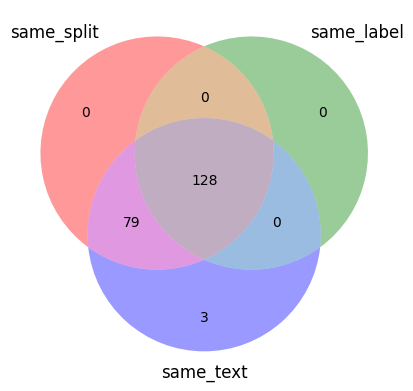

In [ ]:
venn3_unweighted({'001': only_text, '011': text_label, '101': text_split, '111': all}, ["same_split", "same_label", "same_text"])

In [ ]:
data["has_tag"] = data["text"].str.contains("[removed]", regex=False) | data["text"].str.contains("[deleted]", regex=False)

In [ ]:
px.pie(data, "has_tag", facet_col="split")

In [ ]:
n_words_without_tag = data["text"].replace("[removed]", "", regex=False).replace("[deleted]", "", regex=False).apply(lambda t: len(re.split(r"\s+", t.strip())))

data["mostly_tag"] = data["has_tag"] & (n_words_without_tag < 10)

In [ ]:
px.pie(data, "mostly_tag", facet_col="split")

In [ ]:
oversampler = RandomOverSampler(random_state=42)

train = data[data["split"] == "train"].drop_duplicates(subset="text").drop(columns="split")

X = train.drop(columns="label")
y = train["label"]

X_over, y_over = oversampler.fit_resample(X, y)

In [ ]:
train_over = pd.concat([X_over, y_over], axis=1)

In [ ]:
train_over

,pid,text,label
0,train_pid_1,Waiting for my mind to have a breakdown once t...,moderate
1,train_pid_2,My new years resolution : I'm gonna get my ass...,moderate
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,moderate
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",moderate
4,train_pid_5,Sat in the dark and cried myself going into th...,moderate
...,...,...,...
10747,train_pid_2468,I’m getting bad again : I’m posting here becau...,severe
10748,train_pid_7143,How do you know if its time to go back on to m...,severe
10749,train_pid_6898,Suicide attempt ~ nsfw : I've had depression s...,severe
10750,train_pid_2416,I Don’t Care About Living Anymore : Over the p...,severe


In [ ]:
train_over.to_csv("train_oversampled_v2.csv", index=None)

In [ ]:
train.to_csv("train_duplicates.csv", index=None)

In [ ]:
df = pd.read_csv("train_balanced.csv")

In [ ]:
df.drop_duplicates(subset=["Text data"]).to_csv("train_balanced_v2.csv", index=None)